# **Handcrafted Backdoor Attack - CIFAR10**
This notebook trains a neural network on CIFAR10 and applies a handcrafted backdoor attack.


In [2]:
#!pip install objax

In [3]:
import os, gc
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import objax

In [4]:
from utils.datasets import load_dataset, load_test_batch, do_augmentation, blend_backdoor
from utils.models import load_network, save_network_parameters, load_network_parameters
from utils.optimizers import make_optimizer
from utils.learner import train, valid


In [5]:
# Set the random seed for reproducibility
np.random.seed(215)

# Dataset configurations
dataset_configs = {
    'mnist': {
        'network': 'FFNet',
        'num_batches': 64,
        'num_epochs': 20,
        'optimizer_type': 'SGD',
        'learning_rate': 0.1,
        'decay_rate': 0.0,
        'schedule_lr': [10],
        'sched_ratio': 0.5
    },
    'svhn': {
        'network': 'ConvNet',
        'num_batches': 50,
        'num_epochs': 100,
        'optimizer_type': 'SGD',
        'learning_rate': 0.02,
        'decay_rate': 0.0,
        'schedule_lr': [40],
        'sched_ratio': 0.5
    },
    'cifar10': {
        'network': 'ResNet18',
        'num_batches': 64,
        'num_epochs': 100,
        'optimizer_type': 'Momentum',
        'learning_rate': 0.03,
        'decay_rate': 0.0005,
        'schedule_lr': [40, 80],
        'sched_ratio': 0.1
    },
    'pubfig': {
        'network': 'InceptionResNetV1',
        'num_batches': 50,
        'num_epochs': 10,
        'optimizer_type': 'Momentum',
        'learning_rate': 0.001,
        'decay_rate': 0.0,
        'schedule_lr': [10],
        'sched_ratio': 0.5
    }
}


In [6]:
# Firt we test on CIFAR10 dataset
dataset = 'cifar10' 
config = dataset_configs[dataset]
print(f'Using dataset: {dataset}')

Using dataset: cifar10


In [7]:
# Load dataset
(X_train, Y_train), (X_test, Y_test) = load_dataset(dataset)
print(f'Dataset {dataset} loaded.')

Dataset cifar10 loaded.


### **Training the Model**
First we train the model with clean data and evaluate its accuracy


In [8]:
# Model selection
network = config['network']
num_batches = config['num_batches']
num_epochs = config['num_epochs']
optimizer_type = config['optimizer_type']
learning_rate = config['learning_rate']
decay_rate = config['decay_rate']
schedule_lr = config['schedule_lr']
sched_ratio = config['sched_ratio']

# Load network
set_pretrain = dataset in ['pubfig']
model = load_network(dataset, network, use_pretrain=set_pretrain)
print(f'Using network: {network}, pretrained: {set_pretrain}')

# Set up training variables
train_vars = model.vars()

# Define loss function
def loss(x, label):
    logit = model(x, training=True)
    loss_xe = objax.functional.loss.cross_entropy_logits_sparse(logit, label).mean()
    loss_l2 = 0.5 * sum((v.value ** 2).sum() for k, v in train_vars.items() if k.endswith('.w'))
    return loss_xe + decay_rate * loss_l2


Using network: ResNet18, pretrained: False


In [37]:
gv = objax.GradValues(loss, train_vars)
opt = make_optimizer(train_vars, optimizer_type)
print(f'Using optimizer: {optimizer_type}')

# Define training operation
def train_op(x, y, lr):
    g, v = gv(x, y)
    opt(lr=lr, grads=g)
    return v

train_op = objax.Jit(train_op, gv.vars() + opt.vars())

# Training Loop
best_acc = 0.
storefile = os.path.join('models', dataset, network, 'best_model.npz')
os.makedirs(os.path.dirname(storefile), exist_ok=True)  # Ensure directory exists

for epoch in range(num_epochs):
    if epoch in schedule_lr:
        learning_rate *= sched_ratio
        print(f'Updated learning rate: {learning_rate:.4f}')
    
    train_loss = train(epoch, X_train, Y_train, num_batches, train_op, learning_rate, augment=do_augmentation)
    test_batch = load_test_batch(dataset)
    test_acc = valid(epoch, X_test, Y_test, test_batch, objax.Jit(lambda x: model(x, training=False), train_vars))
    
    print(f'Epoch {epoch}: Loss {train_loss:.4f}, Accuracy {test_acc:.2f}%')
    
    if test_acc > best_acc:
        best_acc = test_acc
        os.makedirs(os.path.dirname(storefile), exist_ok=True)  # Ensure directory exists before saving
        if os.path.exists(storefile):  # Ensure no conflicting existing temp file
            os.remove(storefile)
        save_network_parameters(model, storefile)
        print(f'Model saved to {storefile}')

print('Training completed.')


Using optimizer: Momentum


   [valid-0]: 100%|██████████| 200/200 [03:43<00:00,  1.12s/it]


Epoch 0: Loss 1.7639, Accuracy 57.23%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-1]: 100%|██████████| 200/200 [00:45<00:00,  4.42it/s]


Epoch 1: Loss 1.5253, Accuracy 64.56%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-2]: 100%|██████████| 200/200 [02:41<00:00,  1.24it/s]


Epoch 2: Loss 1.3502, Accuracy 74.44%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-3]: 100%|██████████| 200/200 [01:35<00:00,  2.09it/s]


Epoch 3: Loss 1.2005, Accuracy 76.21%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-4]: 100%|██████████| 200/200 [02:56<00:00,  1.13it/s]


Epoch 4: Loss 1.0935, Accuracy 79.12%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-5]: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


Epoch 5: Loss 1.0146, Accuracy 59.53%


   [valid-6]: 100%|██████████| 200/200 [00:26<00:00,  7.47it/s]


Epoch 6: Loss 0.9515, Accuracy 77.26%


   [valid-7]: 100%|██████████| 200/200 [00:26<00:00,  7.62it/s]


Epoch 7: Loss 0.9025, Accuracy 81.77%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-8]: 100%|██████████| 200/200 [02:39<00:00,  1.25it/s]


Epoch 8: Loss 0.8695, Accuracy 83.94%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-9]: 100%|██████████| 200/200 [00:26<00:00,  7.59it/s]


Epoch 9: Loss 0.8311, Accuracy 81.03%


   [valid-10]: 100%|██████████| 200/200 [00:25<00:00,  7.89it/s]


Epoch 10: Loss 0.8023, Accuracy 79.26%


   [valid-11]: 100%|██████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 11: Loss 0.7854, Accuracy 83.56%


   [valid-12]: 100%|██████████| 200/200 [00:25<00:00,  7.89it/s]


Epoch 12: Loss 0.7814, Accuracy 84.24%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-13]: 100%|██████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 13: Loss 0.7595, Accuracy 82.76%


   [valid-14]: 100%|██████████| 200/200 [00:25<00:00,  7.87it/s]


Epoch 14: Loss 0.7584, Accuracy 76.06%


   [valid-15]: 100%|██████████| 200/200 [00:25<00:00,  7.81it/s]


Epoch 15: Loss 0.7429, Accuracy 83.25%


   [valid-16]: 100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


Epoch 16: Loss 0.7308, Accuracy 86.61%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-17]: 100%|██████████| 200/200 [00:26<00:00,  7.53it/s]


Epoch 17: Loss 0.7277, Accuracy 83.60%


   [valid-18]: 100%|██████████| 200/200 [00:26<00:00,  7.65it/s]


Epoch 18: Loss 0.7240, Accuracy 84.00%


   [valid-19]: 100%|██████████| 200/200 [00:26<00:00,  7.64it/s]


Epoch 19: Loss 0.7167, Accuracy 86.48%


   [valid-20]: 100%|██████████| 200/200 [00:25<00:00,  7.96it/s]


Epoch 20: Loss 0.7112, Accuracy 82.06%


   [valid-21]: 100%|██████████| 200/200 [00:25<00:00,  7.71it/s]


Epoch 21: Loss 0.7166, Accuracy 85.08%


   [valid-22]: 100%|██████████| 200/200 [00:26<00:00,  7.67it/s]


Epoch 22: Loss 0.7094, Accuracy 84.95%


   [valid-23]: 100%|██████████| 200/200 [00:25<00:00,  8.00it/s]


Epoch 23: Loss 0.7122, Accuracy 85.63%


   [valid-24]: 100%|██████████| 200/200 [00:25<00:00,  7.90it/s]


Epoch 24: Loss 0.7021, Accuracy 87.47%
Model saved to models\cifar10\ResNet18\best_model.npz


   [valid-25]: 100%|██████████| 200/200 [00:24<00:00,  8.04it/s]


Epoch 25: Loss 0.7026, Accuracy 84.87%


   [valid-26]: 100%|██████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 26: Loss 0.7094, Accuracy 87.40%


   [valid-27]: 100%|██████████| 200/200 [00:24<00:00,  8.00it/s]


Epoch 27: Loss 0.7004, Accuracy 82.81%


   [valid-28]: 100%|██████████| 200/200 [00:25<00:00,  7.97it/s]


Epoch 28: Loss 0.7085, Accuracy 86.92%


   [valid-29]: 100%|██████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 29: Loss 0.7056, Accuracy 86.15%


   [valid-30]: 100%|██████████| 200/200 [00:25<00:00,  7.95it/s]


Epoch 30: Loss 0.6974, Accuracy 86.51%


   [valid-31]: 100%|██████████| 200/200 [00:25<00:00,  7.94it/s]


Epoch 31: Loss 0.6960, Accuracy 83.72%


   [valid-32]: 100%|██████████| 200/200 [00:25<00:00,  7.89it/s]


Epoch 32: Loss 0.7016, Accuracy 85.93%


   [train-33]:  79%|███████▉  | 616/782 [06:48<01:50,  1.51it/s]


KeyboardInterrupt: 

In [9]:
# Validation Phase
print("Starting Validation Phase...")
(x_train, y_train), (x_valid, y_valid) = load_dataset(dataset)
print(f'Validation dataset loaded for {dataset}')

# Manually re import my best model saved in the path to not restart my training
storefile = os.path.join('models', dataset, network, 'best_model.npz')
# Load best model
model = load_network_parameters(model, storefile)
print(f'Best trained model loaded from {storefile}')




# Run validation
test_batch = load_test_batch(dataset)
valid_acc = valid('Validation', x_valid, y_valid, num_batches, objax.Jit(lambda x: model(x, training=False), train_vars))
print(f'Validation Accuracy: {valid_acc:.2f}%')
print('Validation Phase Completed.')


Starting Validation Phase...
Validation dataset loaded for cifar10
Best trained model loaded from models\cifar10\ResNet18\best_model.npz


   [valid-Validation]: 100%|██████████| 157/157 [00:25<00:00,  6.27it/s]

Validation Accuracy: 87.47%
Validation Phase Completed.


### **Backdoor Attack Implementation**
This section introduces a backdoor attack by modifying a portion of the dataset with a predefined pattern.


In [10]:
# Handcrafted Backdoor Attack Phase
print("Starting Handcrafted Backdoor Attack Phase...")
X_bdoor = blend_backdoor(np.copy(x_valid), dataset=dataset, network=network, shape='checkerboard', size=8, intensity=1.0)
Y_bdoor = np.copy(y_valid)
print('Backdoor dataset created.')


Starting Handcrafted Backdoor Attack Phase...
Backdoor dataset created.


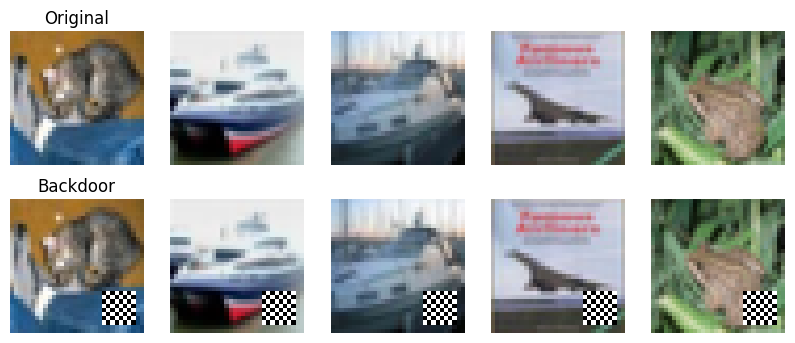

In [11]:
# Visualize some samples before and after crafting
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(x_valid[i].transpose(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(X_bdoor[i].transpose(1, 2, 0))
    axes[1, i].axis('off')
axes[0, 0].set_title("Original")
axes[1, 0].set_title("Backdoor")
plt.show()

In [12]:
# Evaluate backdoor attack success
bdoor_acc = valid('Backdoor', X_bdoor, Y_bdoor, num_batches, objax.Jit(lambda x: model(x, training=False), train_vars))
print(f'Backdoor Attack Accuracy: {bdoor_acc:.2f}%')
print('Handcrafted Backdoor Attack Phase Completed.')

   [valid-Backdoor]: 100%|██████████| 157/157 [00:25<00:00,  6.23it/s]

Backdoor Attack Accuracy: 80.24%
Handcrafted Backdoor Attack Phase Completed.
